# Тренировка простой сверточной нейросети на датасете MNIST.

[Источник](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py)

## Импорт необходимых библиотек

Ссылки на сторонние библиотеки:

[matplotlib](https://matplotlib.org/)

[keras](https://keras.io/)

[numpy](http://www.numpy.org/)

Нажмите `Shift+Enter`, чтобы выполнить код в ячейке.

In [1]:
%matplotlib inline
# Библиотека для работы с графиками и изображениями
import matplotlib
from matplotlib import pyplot as plt

# Одна из библиотек для работы с нейросетями
import keras
# Класс для работы с датасетом MNIST
from keras.datasets import mnist
# Класс для создания модели
from keras.models import Sequential
# Классы полносвязных слоев, 
# Dropout слой (отсечение значений на входе, меньше заданного), 
# Flatten слой (изменяет размерность входных данных модели)
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
# Класс для просмотра backend'а (Tensorflow или Treano)
from keras import backend as K

# Библиотека для быстрой работы с многомерными массивами
import numpy as np

# Встроенный модуль языка Python, который предоставляет функции для генерации случайных чисел,
# букв, случайного выбора элементов последовательности.
import random

# Модуль, который обеспечивает доступ к некоторым переменным и функциям,
# взаимодействующим с интерпретатором python.
import sys

# Вывод версий пакетов
print('Версия python3:', sys.version)
print('Версия keras:', keras.__version__)
print('Версия matplotlib:', matplotlib.__version__)
print('Версия numpy', np.__version__)

Using TensorFlow backend.


Версия python3: 3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Версия keras: 2.0.9
Версия matplotlib: 1.5.3
Версия numpy 1.11.1


## Задание параметров для обучения

In [2]:
# Размер пакета для обучения (Можно попробовать менять)
batch_size = 128
# Число классов (лучше не трогать, потому что цифр в датасете от 0 до 9)
num_classes = 10
# Число эпох (шагов обучения на датасете), можно менять
epochs = 1

# Размер изображение, которое подается на вход нейросети. 
# Менять в соответствии с возможностями машины (оперативная память)
img_rows, img_cols = 28, 28

In [3]:
# Получить данные, предварительно размешанные и разделенные для обучения и теста.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Форматирование размерности входных данных в зависимости от backend'а.

In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

## Препроцессинг изображений. 
Так как нейросеть работает с числами от 0 до 1, то данные нужно нормировать. Для кодирования класса воспользуемся `to_categorical` из модуля keras.utils.

In [5]:
# Нормировка данных
x_train_ = x_train.astype('float32')
x_test_ = x_test.astype('float32')
x_train_ /= 255
x_test_ /= 255
print('x_train_ shape:', x_train_.shape)
print(x_train_.shape[0], 'train samples')
print(x_test_.shape[0], 'test samples')
# Кодирование классов в бинарные вектора (по сути, One-hot-encoding)
y_train_ = keras.utils.to_categorical(y_train, num_classes)
y_test_ = keras.utils.to_categorical(y_test, num_classes)

x_train_ shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
# Проверим классы
classes = np.unique(y_train)
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [7]:
# Вывод картинок
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("Нет изображений")
        return 
    else:
        # Берем 9 картинок случайным образом
        random_indices = random.sample(range(len(images)), min(len(images), 9))
            
    # Для отображения результатов предсказывания
    if cls_pred is None:
        images, cls_true = zip(*[(images[i], cls_true[i]) for i in random_indices])
    else:
        images, cls_true, cls_pred = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    
    # Создания рисунка с 3*3 графиками
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Вывод изображение
        image = images[i]
        ax.imshow(image)

        # Показать истинный класс и предсказанный класс объекта
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Показать классы как ось графика
        ax.set_xlabel(xlabel)
        
        # Убрать шкалу по осям
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Корректный вывод изображений в ячейке Jupyter
    plt.show()

## Просмотр данных для обучения

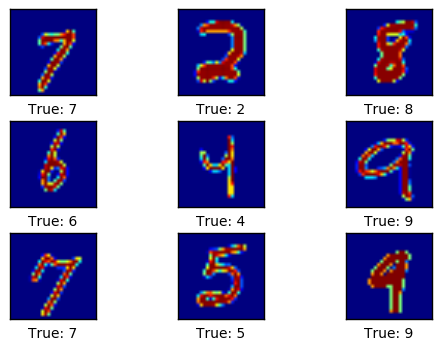

In [8]:
plot_images(x_train[:,:,:,0], y_train, cls_pred=None)

## Просмотр данных для теста

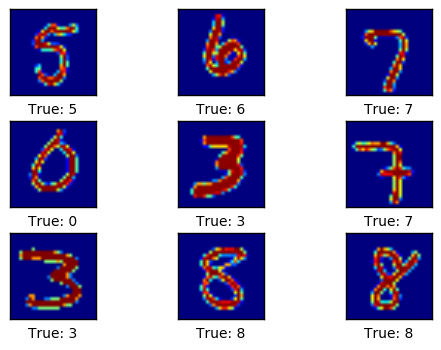

In [9]:
plot_images(x_test[:,:,:,0], y_test, cls_pred=None)

## Архитектура нейросети

In [10]:
# https://keras.io/models/sequential/
model = Sequential()

# https://ru.wikipedia.org/wiki/Свёрточная_нейронная_сеть
# https://keras.io/layers/convolutional/
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))

# https://keras.io/layers/pooling/
model.add(MaxPooling2D(pool_size=(2, 2)))

# https://keras.io/layers/core/
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# https://www.quora.com/What-are-differences-between-update-rules-like-AdaDelta-RMSProp-AdaGrad-and-AdaM
# https://ru.wikipedia.org/wiki/Перекрёстная_энтропия (crossentropy)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

## Обучение

In [11]:
model.fit(x_train_, y_train_,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_, y_test_))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 410s 7ms/step - loss: 1.9368 - acc: 0.3529 - val_loss: 0.9445 - val_acc: 0.7444


## Оценка качества классификации

In [16]:
score = model.evaluate(x_test_, y_test_, verbose=0)
print('Потери на тесте:', score[0])
print('Точность на тесте:', score[1])

Потери на тесте: 0.944513345051
Точность на тесте: 0.7444


## Вывод результатов

In [17]:
def plot_example_errors_rights(cls_pred, correct):

    incorrect = (correct == False)
    
    images_incorrect = x_test[incorrect,:,:,0]
    
    cls_pred_incorrect = cls_pred[incorrect]

    labels = y_test
    cls_true_incorrect = labels[incorrect]
    
    print('Ошибки классификации')
    plot_images(images=images_incorrect[0:9],
                cls_true=cls_true_incorrect[0:9],
                cls_pred=cls_pred_incorrect[0:9])
    
    images_correct = x_test[correct,:,:,0]
    
    cls_pred_correct = cls_pred[correct]

    cls_true_correct = labels[correct]
    
    print('Правильная классификация')
    plot_images(images=images_correct[0:9],
                cls_true=cls_true_correct[0:9],
                cls_pred=cls_pred_correct[0:9])

In [18]:
def print_validation_accuracy(show_example_errors_rights=False):
    
    cls_pred = np.array([np.argmax(x) for x in model.predict(x_test_)], dtype=np.int)
    
    cls_true = y_test

    correct = (cls_true == cls_pred)

    correct_sum = correct.sum()

    acc = float(correct_sum) / len(y_test)

    msg = "Точность на поверочном множестве: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, len(y_test)))

    if show_example_errors_rights:
        print("Примеры ошибок и правильных классификаций:")
        plot_example_errors_rights(cls_pred=cls_pred, correct=correct)

## Результаты

Точность на поверочном множестве: 74.4% (7444 / 10000)
Примеры ошибок и правильных классификаций:
Ошибки классификации


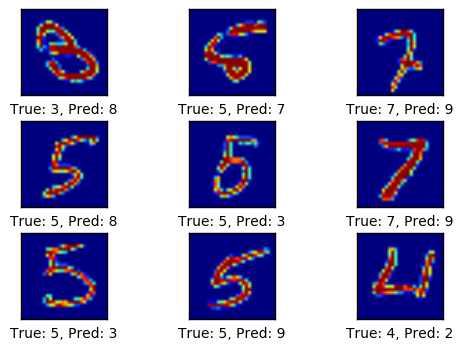

Правильная классификация


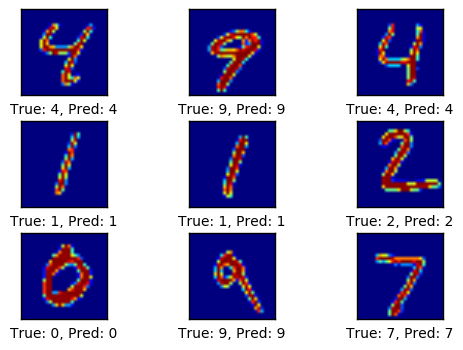

CPU times: user 16.3 s, sys: 1.12 s, total: 17.4 s
Wall time: 19 s


In [19]:
%%time

print_validation_accuracy(show_example_errors_rights=True)